In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5pyd
import pandas as pd
import windrose as wr
import astral

In [2]:
from mmctools.helper_functions import theta
from mmctools.helper_functions import T_to_Tv, calc_uv
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [3]:
# constants
k = 0.4      # von Karman constant
g = 9.81
Rd = 287.05  # gas constant for dry air [J kg^-1 K-1]
Cp = 1004.   # specific heat at constant pressure for dry air [J kg^-1 K-1]

# WIND Toolkit Analysis (updated dataset)
# Part 4 - Case selection and diurnal cycle

Regis Thedin \
Dec 2020

## - Read saved feather files

In [4]:
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfsc = pd.read_feather(os.path.join('data','dfsc.ftr')).set_index(['datetime','height'])
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfold = pd.read_feather(os.path.join('data','dfold.ftr')).set_index(['datetime','height'])
dfcasp = pd.read_feather(os.path.join('data','dfcasp.ftr')).set_index(['datetime'])

In [5]:
# Aux variables for plotting
dfnames = ['old WTK','single column','20x20 km avg','KCPR airport']
season_names = ['winter','spring','summer','fall']
month_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# hours unique
hours_u = np.arange(0,24)

# heights where wind data are available for dfsc and df20km
heights_wind = np.concatenate((np.array([10]),np.arange(20,201,20)))
# unique heights
heights_u = df20km.index.levels[1]

# hub height for wind roses
zhub = 80

In [6]:
# Auxiliary windrose plots variables
rec2x2 = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
rec4x1 = [[0.00,0.00,0.22,1],[0.25,0.00,0.22,1],[0.50,0.00,0.22,1],[0.75,0.00,0.22,1]]
rec4x2 = [[0.00,0.50,0.22,0.45],[0.25,0.50,0.22,0.45],[0.50,0.50,0.22,0.45],[0.75,0.50,0.22,0.45],\
          [0.00,0.00,0.22,0.45],[0.25,0.00,0.22,0.45],[0.50,0.00,0.22,0.45],[0.75,0.00,0.22,0.45]]
rec4x4 = [[0.00,0.75,0.22,0.22],[0.25,0.75,0.22,0.22],[0.50,0.75,0.22,0.22],[0.75,0.75,0.22,0.22],\
          [0.00,0.50,0.22,0.22],[0.25,0.50,0.22,0.22],[0.50,0.50,0.22,0.22],[0.75,0.50,0.22,0.22],\
          [0.00,0.25,0.22,0.22],[0.25,0.25,0.22,0.22],[0.50,0.25,0.22,0.22],[0.75,0.25,0.22,0.22],\
          [0.00,0.00,0.22,0.22],[0.25,0.00,0.22,0.22],[0.50,0.00,0.22,0.22],[0.75,0.00,0.22,0.22]]

bins=([0,2,4,6,8,10,12,14])

wrlabels = ['','NE','','NW','','SW','','SE']

In [7]:
# Copy wind direction info from zhub to 0m so it's easier to slice/loc dataframe with hfx information
df20km.loc[(slice(None),0),'dir'] = df20km.xs(zhub, level='height')['dir'].values

In [8]:
# Add convective velocity information
for df in df20km,dfsc:
    zi = df['z_i'].xs(0,level='height').values
    Tw = df['hfx_Kms'].xs(0,level='height').values
    Temp = df['thetav'].xs(2,level='height').values
    df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))

<ipython-input-8-ef6c233e135c>:6: RuntimeWarning: invalid value encountered in power
  df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))


In [9]:
# Add thermal updraft information
for df in dfsc, df20km:
    zi = df['z_i'].xs(0,level='height').repeat(len(heights_u)).values
    z = df.reset_index()['height'].values
    df['wT'] = df['wstar']*0.85*(z/zi)**(1/3)*(1.3-z/zi)

## 7. Cases to run

Given the plots above, we select a few canonical conditions to run


### 7.1. Estimate the surface roughness
Using the simple expression 

\begin{equation}
u = \frac{u_*}{\kappa} \ln \left( \frac{z}{z_0} \right)
\end{equation}

that really only applies to unobstructed neutral conditions. We will only check neutral conditions.

In [10]:
z = df20km.index.get_level_values(level='height')
ustar = df20km['ustar'].xs(0,level='height').repeat(len(heights_u)).values
df20km['z0'] = z* np.exp(-df20km['windspeed']*k/ustar)

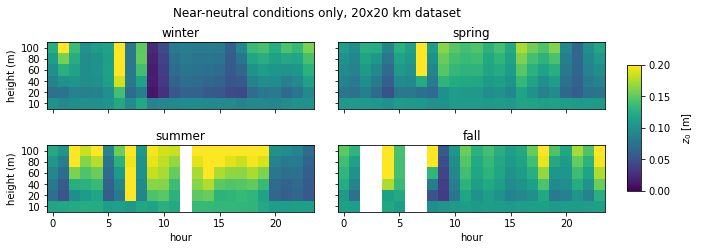

In [11]:
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,3.5))
fig.suptitle('Near-neutral conditions only, 20x20 km dataset',fontsize=12)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()
heights_z0 = heights_wind[:6]

for s in range(4):
    seasonaldataN = df20km.loc[df20km['stability']=='N'].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_z0),len(hours_u)))
    for (i,z) in enumerate(heights_z0):
        for (j,h) in enumerate(hours_u): 
            try:
                ws[i,j] = seasonaldataN.loc[(s,h,z)]['z0']    
            except KeyError:
                ws[i,j] = np.nan
                    
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=0, vmax=0.2)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('$z_0$ [m]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.arange(len(heights_z0)))
    axi.set_yticklabels(heights_z0)

We will use the surface roughness obtained using $u(80m)$, during daytime over the spring

In [12]:
cond = (df20km['stability']=='N') & (df20km['season']==1) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_sp = df20km.loc[cond].xs(80,level='height')['z0'].mean()

In [13]:
cond = (df20km['stability']=='N') & (df20km['season']==0) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_wi = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==1) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_sp = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==2) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_su = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==3) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_fa = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_all = df20km.loc[cond].xs(80,level='height')['z0'].mean()

In [14]:
print(f'The average surface roughness during the day under neutral conditions is:')
print(f'Winter: {z0_z80_neutral_wi:.4f} m\nSpring: {z0_z80_neutral_sp:.4f} m')
print(f'Summer: {z0_z80_neutral_su:.4f} m\nFall: {z0_z80_neutral_fa:.4f} m')
print(f'All year: {z0_z80_neutral_all:.4f} m')

The average surface roughness during the day under neutral conditions is:
Winter: 0.0808 m
Spring: 0.1713 m
Summer: 0.1821 m
Fall: 0.1222 m
All year: 0.1260 m


### 7.2. Boundary layer height

In [15]:
df20km['z_i']

datetime                   height
2016-12-31 17:00:00-07:00  0.0       240.61145
                           2.0             NaN
                           10.0            NaN
                           20.0            NaN
                           40.0            NaN
                                       ...    
2018-12-31 16:00:00-07:00  120.0           NaN
                           140.0           NaN
                           160.0           NaN
                           180.0           NaN
                           200.0           NaN
Name: z_i, Length: 227760, dtype: float64

In [16]:
datefrom=df20km.index.levels[0][0]
dateto=df20km.index.levels[0][10000]

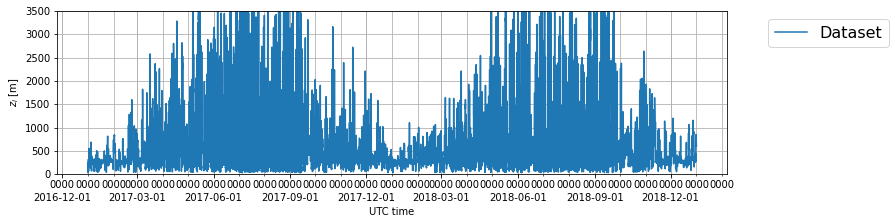

In [17]:
fig, ax = plot_timehistory_at_height(
    df20km,
    fields=['z_i'],
    heights=0,
    #timelimits=[datefrom, dateto],
    fieldlabels={'z_i':r'$z_i$ [m]'},
    fieldlimits={'z_i':[0,3500]},
    showlegend=True,
    #plot_local_time=True,
    #local_time_offset=-7,
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

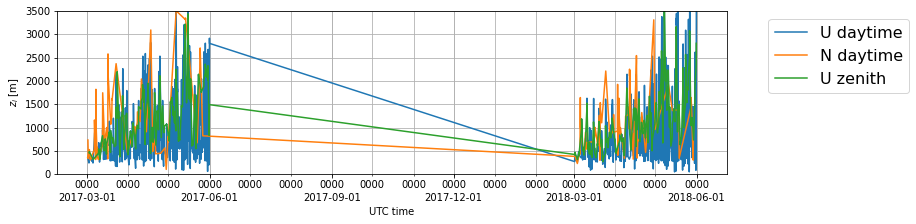

In [18]:
fig, ax = plot_timehistory_at_height(
    datasets={
              'U daytime':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['season']==1)], \
             #'U nighttime':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) &  ((df['hour']<6)|(df['hour']>=18)) & (df20km['season']==1)], \
              'N daytime':df20km.loc[(df20km['stability']=='N') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['season']==1)], \
             #'N nighttime':df20km.loc[(df20km['stability']=='N') & ((df['hour']<6)|(df['hour']>=18)) & (df20km['season']=1)], \
              'U zenith':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) & (df20km['hour']>=12) & (df20km['hour']<14) & (df20km['season']==1)], \
             #'N zenith':df20km.loc[(df20km['stability']=='N') & (df20km['hour']>=12) & (df20km['hour']<14) & (df20km['season']==1)], \
             },
    fields=['z_i'],
    heights=0,
    #timelimits=[datefrom, dateto],
    fieldlabels={'z_i':r'$z_i$ [m]'},
    fieldlimits={'z_i':[0,3500]},
    showlegend=True,
    #plot_local_time=True,
    #local_time_offset=-7,
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

### 7.3. Summary of cases


Neutral cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv .| heat flux  | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:---------------:|:----------:|:------:|
| early spring neutral   | WSW 247.5 deg | 10 m/s     | 0.17 m | 8 K             |  0 K-m/s   |  750 m |
| late spring neutral    | WSW 247.5 deg | 12 m/s     | 0.17 m | 8 K             |  0 K-m/s   |  750 m |

Convective cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv | heat flux  | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:--------------:|:----------:|:------:|
| early spring unstable  | WSW 247.5 deg | 6 m/s      | 0.17 m | 10 K           | 0.12 K-m/s | 1.5 km |
| late spring unstable   | WSW 247.5 deg | 8 m/s      | 0.17 m | 10 K           | 0.20 K-m/s | 2 km |
| late spring unstable   | ESE 112.5deg  | 6 m/s      | 0.17 m | 10 K           | 0.12 K-m/s | 2 km |
| late spring unstable   | ESE 112.5deg  | 6 m/s      | 0.17 m | 10 K           | 0.20 K-m/s | 2 km |

In Chris Farmer's presentation, he has some wind direction associated with fatalities. It is also mentioned that "high-risk flights peaked between 190 and 220 degrees". Trying to use some of his cases to compare, these are the additional scenarios:

Neutral cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv .| heat flux | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:---------------:|:---------:|:------:|
| 11 fatalities          | WSW 240 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |
| 2 fatalities           | WNW 290 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |
| 2 fatalities           | SSW 190 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |


## 7.4. Diurnal cycle
Here I will use the a maximum heat flux as the peak during the day and come up with a generic parabola that reflects a more realistic day. The goal is that by not feeding high heat flux for many hours, the turbulence statistics remain realistic.

### 7.4.1. Identify potential days
In the MMC report for year 2, the following conditions are their selection criteria for a quiescent diurnal cycle:

- Consistent wind speed; difference in the average wind speed over 24-hrs is less than 15 m/s.
- Consistent wind direction; average wind direction standard deviation over 24 hrs is less than 40 deg.

In [19]:
df20km['u'], df20km['v'] = calc_uv(df20km, wspd='windspeed', wdir='winddirection')
df20km['w'] = 0
df = df20km.copy()
df.columns

Index(['z_i', 'ustar', 'inverseL_2m', 'latent_hfx', 'precipRate', 'pressure',
       'RH_2m', 'skinTemp', 'hfx_Wm2', 'SST', 'temperature', 'tke',
       'winddirection', 'windspeed', 'theta', 'thetav', 'density', 'hfx_Kms',
       'dir', 'hour', 'inverseLeq', 'zoverL_2m', 'zoverLeq', 'stability',
       'season', 'month', 'wstar', 'wT', 'z0', 'u', 'v', 'w'],
      dtype='object')

In [20]:
df80 = df20km.xs(80, level='height').copy()

In [21]:
df80['winddirectiondiff'] = df80['winddirection'].diff()
df80['windspeeddiff'] = df80['windspeed'].diff()

### Spring 2017

In [39]:
sp2017start = pd.to_datetime('03-01-2017')
sp2017end = pd.to_datetime('06-21-2017')

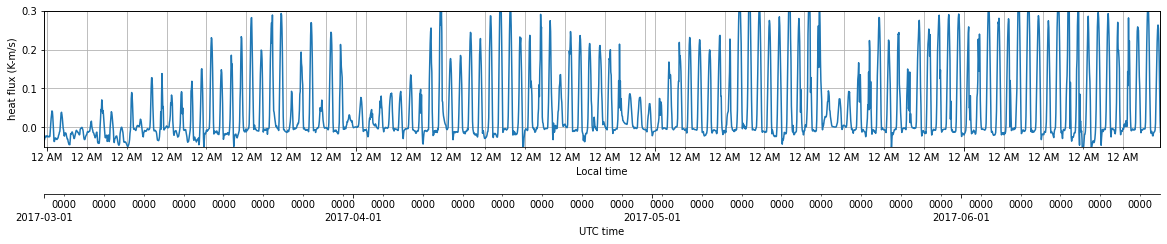

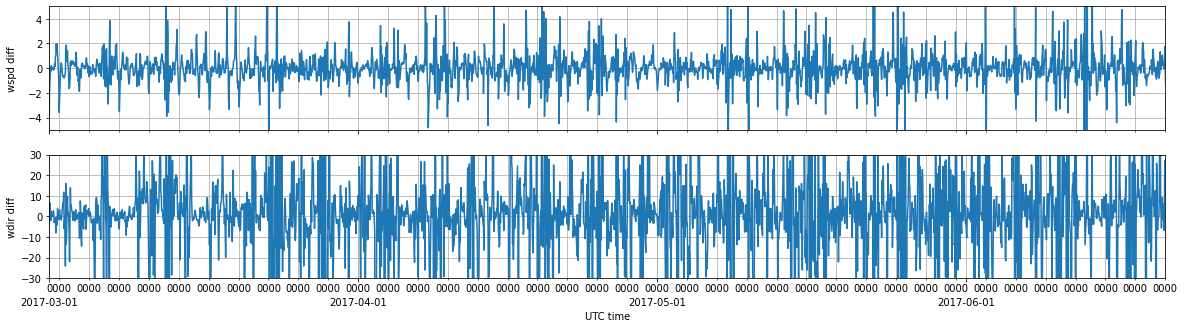

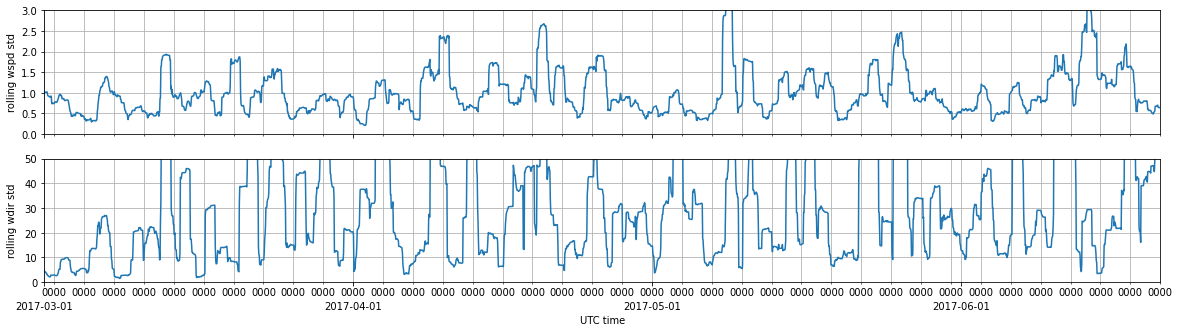

In [37]:
fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[sp2017start, sp2017end],
    fieldlimits={'hfx_Kms':[-0.05,0.3]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(20,2.5),
    plot_local_time=True,
    local_time_offset=-7,
)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=4))

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=4))

fig, axs = plot_timehistory_at_height(df80,
    fields=['windspeeddiff','winddirectiondiff'],
    timelimits=[sp2017start, sp2017end],
    fieldlimits={'windspeeddiff':[-5, 5], 'winddirectiondiff':[-30, 30]},
    fieldlabels={'windspeeddiff':'wspd diff', 'winddirectiondiff':'wdir diff'},
    subfigsize=(20,2.5),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))


fig, axs = plot_timehistory_at_height(
    df80.rolling(24,win_type='triang').std(),
    fields=['windspeeddiff','winddirectiondiff'],
    timelimits=[sp2017start, sp2017end],
    fieldlimits={'windspeeddiff':[0, 3], 'winddirectiondiff':[0, 50]},
    subfigsize=(20,2.5),
    fieldlabels={'windspeeddiff':'rolling wspd std', 'winddirectiondiff':'rolling wdir std'},
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))

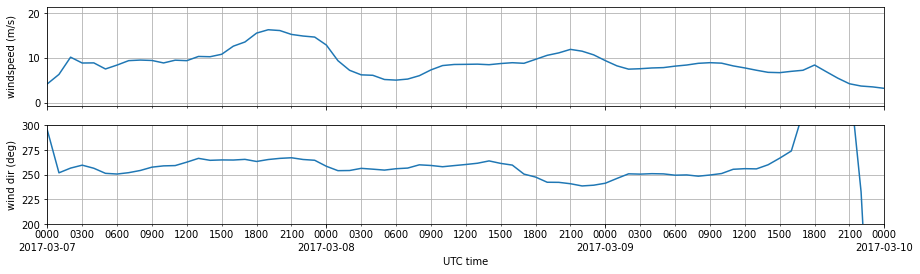

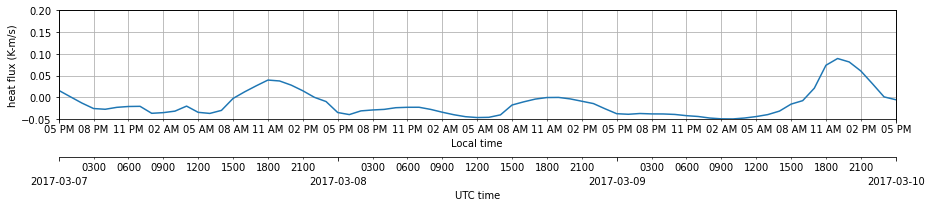

In [42]:
# there is a good candidate after 6 days of the beginning of the plot above.
datestart=pd.to_datetime('03-07-2017')
dateend=pd.to_datetime('03-10-2017')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    fieldlimits={'winddirection':[200,300]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=3))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.2]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=3))

The interval above looks good, however, the wind direction is very aligned. Let's try some different ones.

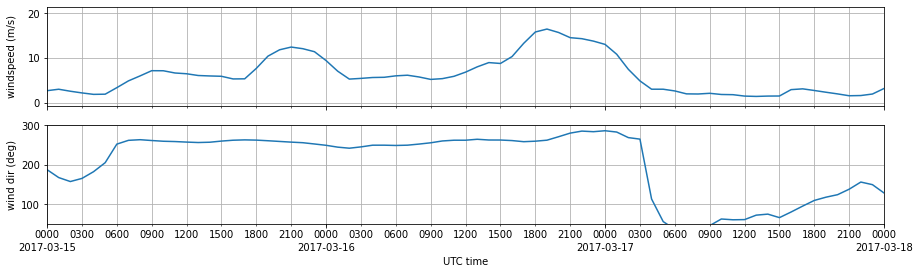

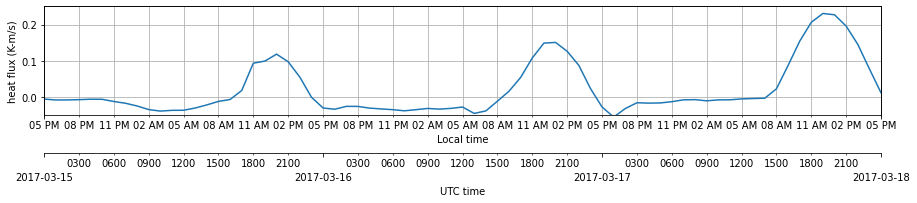

In [53]:
datestart=pd.to_datetime('03-15-2017')
dateend=pd.to_datetime('03-18-2017')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    fieldlimits={'winddirection':[50,300]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=3))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.25]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=3))

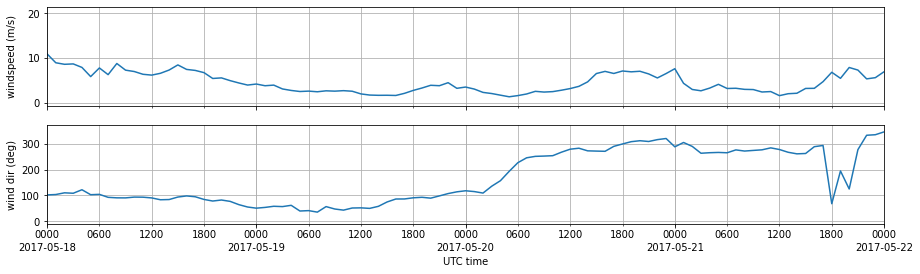

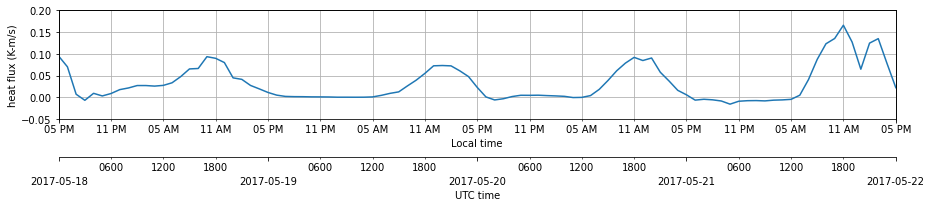

In [44]:
datestart=pd.to_datetime('05-18-2017')
dateend=pd.to_datetime('05-22-2017')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    #fieldlimits={'winddirection':[200,300]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=6))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.2]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

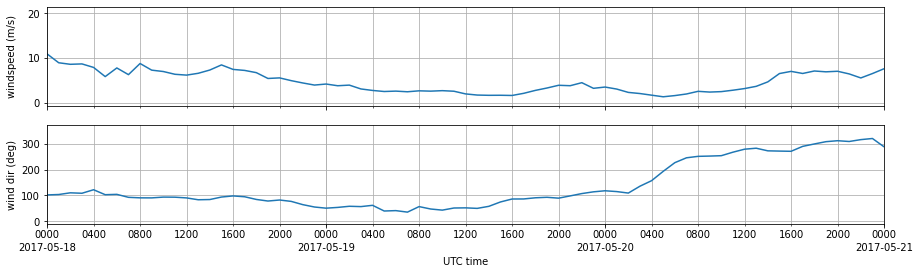

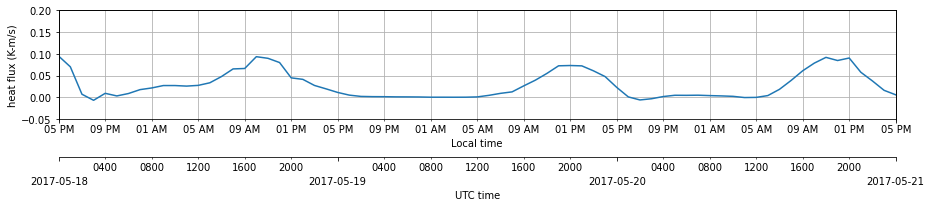

In [46]:
#zooming in on the plots above

datestart=pd.to_datetime('05-18-2017')
dateend=pd.to_datetime('05-21-2017')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    #fieldlimits={'winddirection':[200,300]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=4))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.2]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

### Spring 2018

In [48]:
sp2018start = pd.to_datetime('03-01-2018')
sp2018end = pd.to_datetime('06-21-2018')

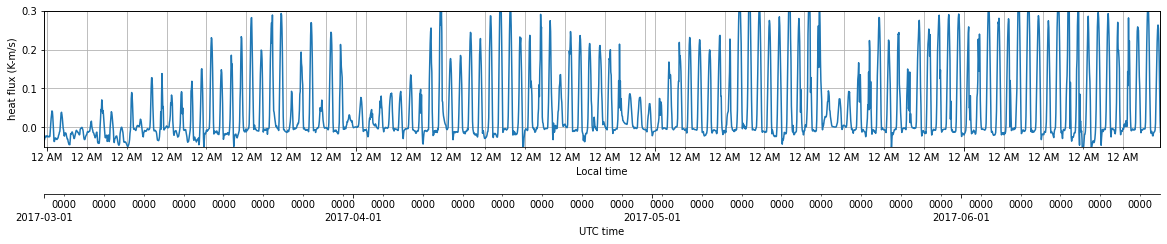

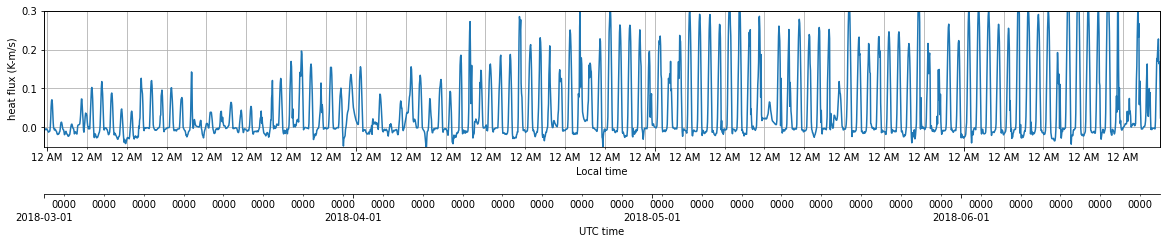

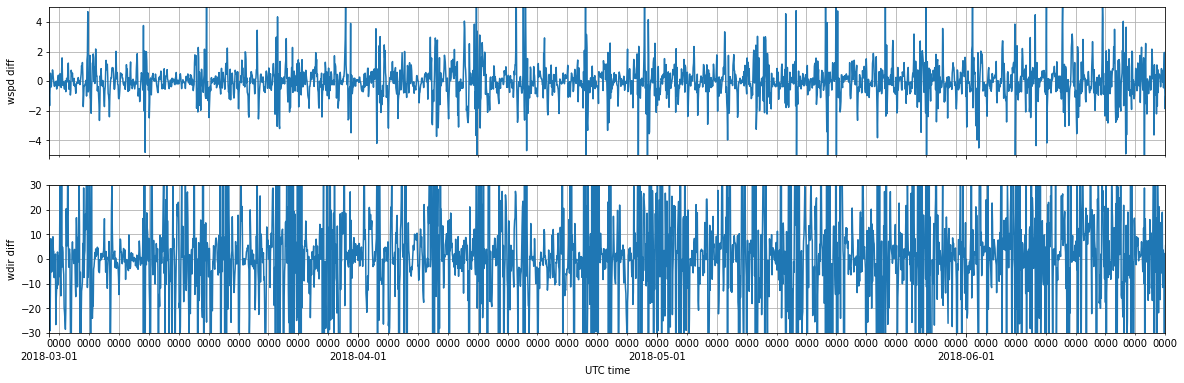

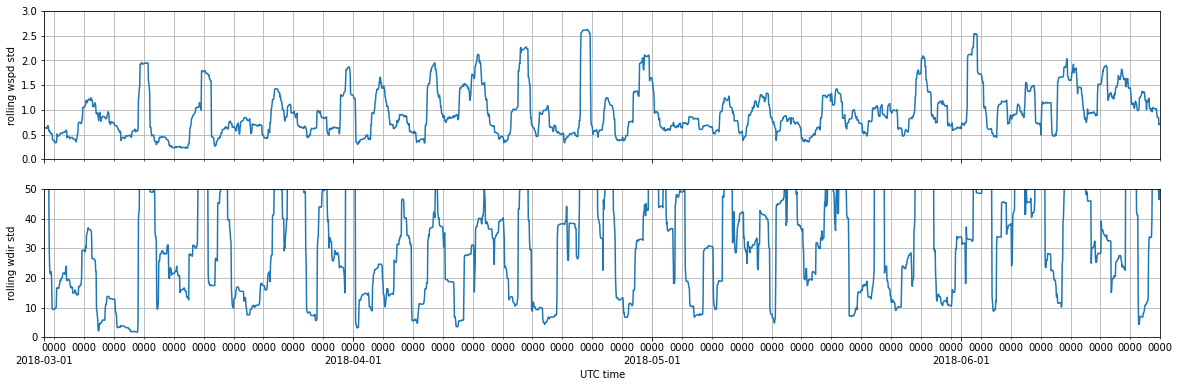

In [54]:
fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[sp2017start, sp2017end],
    fieldlimits={'hfx_Kms':[-0.05,0.3]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(20,2.5),
    plot_local_time=True,
    local_time_offset=-7,
)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=4))

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=4))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[sp2018start, sp2018end],
    fieldlimits={'hfx_Kms':[-0.05,0.3]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(20,2.5),
    plot_local_time=True,
    local_time_offset=-7,
)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=4))

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=4))



fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeeddiff','winddirectiondiff'],
    timelimits=[sp2018start, sp2018end],
    fieldlimits={'windspeeddiff':[-5, 5], 'winddirectiondiff':[-30, 30]},
    fieldlabels={'windspeeddiff':'wspd diff', 'winddirectiondiff':'wdir diff'},
    subfigsize=(20,3),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))



fig, axs = plot_timehistory_at_height(
    df80.rolling(24,win_type='triang').std(),
    fields=['windspeeddiff','winddirectiondiff'],
    timelimits=[sp2018start, sp2018end],
    fieldlimits={'windspeeddiff':[0, 3], 'winddirectiondiff':[0, 50]},
    subfigsize=(20,3),
    fieldlabels={'windspeeddiff':'rolling wspd std', 'winddirectiondiff':'rolling wdir std'},
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))

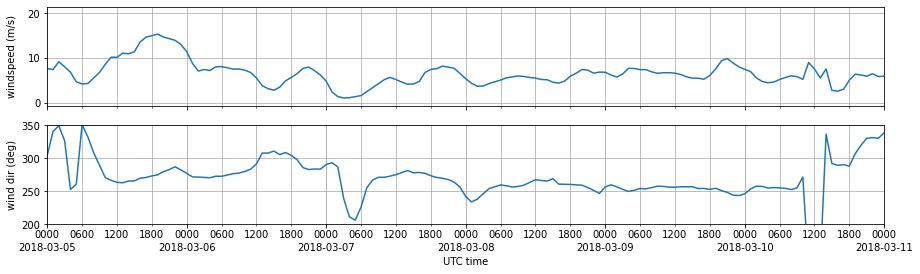

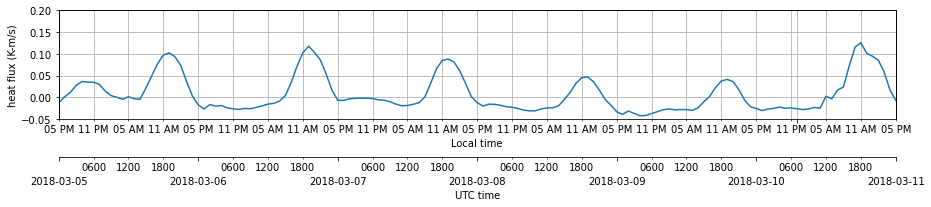

In [50]:
datestart=pd.to_datetime('03-5-2018')
dateend=pd.to_datetime('03-11-2018')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    fieldlimits={'winddirection':[200,350]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=6))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.2]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=6))


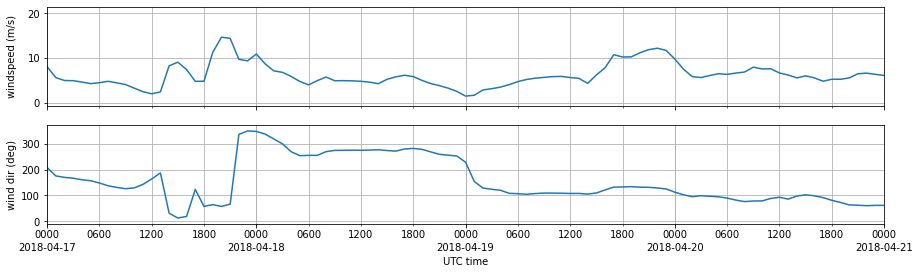

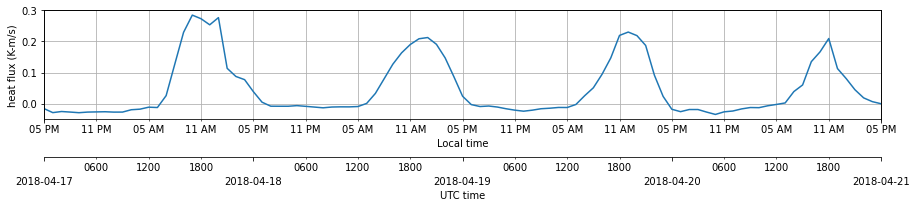

In [51]:
datestart=pd.to_datetime('04-17-2018')
dateend=pd.to_datetime('04-21-2018')

fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection'],
    timelimits=[datestart,dateend],
    #fieldlimits={'winddirection':[200,350]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=6))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms'],
    timelimits=[datestart,dateend],
    fieldlimits={'hfx_Kms':[-0.05,0.3]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)'},
    subfigsize=(15,2),
    plot_local_time=True,
    local_time_offset=-7,
)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=6))


### High heat flux candidate
Includes drastic change of direction

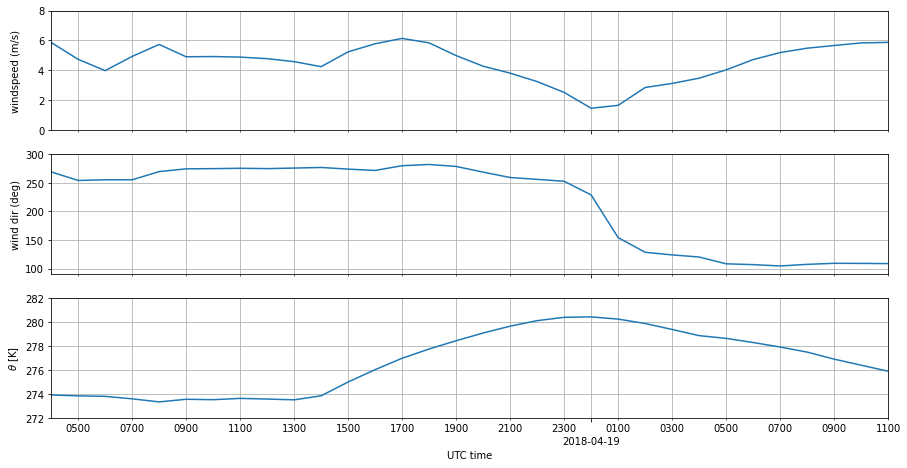

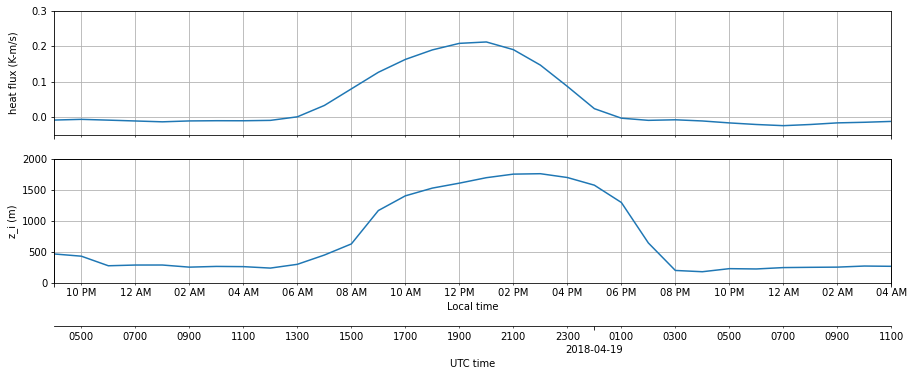

In [71]:
# good candidate for high heating and change in wind speed
datefromhighq = pd.to_datetime('04-18-2018 04Z').tz_convert('US/Mountain')
datetohighq = pd.to_datetime('04-19-2018 11Z').tz_convert('US/Mountain')

# there is a another good candidate 
fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection','theta'],
    timelimits=[datefromhighq, datetohighq],
    fieldlimits={'winddirection':[90,300],'windspeed':[0, 8],'theta':[272,282]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2.5),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=2))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms','z_i'],
    timelimits=[datefromhighq, datetohighq],
    fieldlimits={'hfx_Kms':[-0.05,0.3],'z_i':[0,2000]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)','z_i':'z_i (m)'},
    subfigsize=(15,2.5),
    plot_local_time=True,
    local_time_offset=-7,
)

#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1[0].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=2))

### Low heat flux candidate
Wind speed and wind direction are roughly constant

In [33]:
# This is the best candidate for low heating
datefromlowq = pd.to_datetime('03-08-2018 00Z').tz_convert('US/Mountain')
datetolowq = pd.to_datetime('03-09-2018 18Z').tz_convert('US/Mountain')

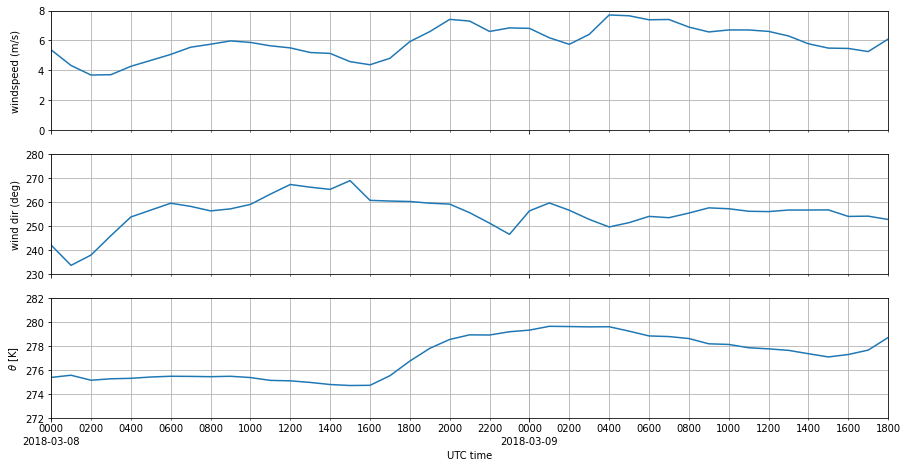

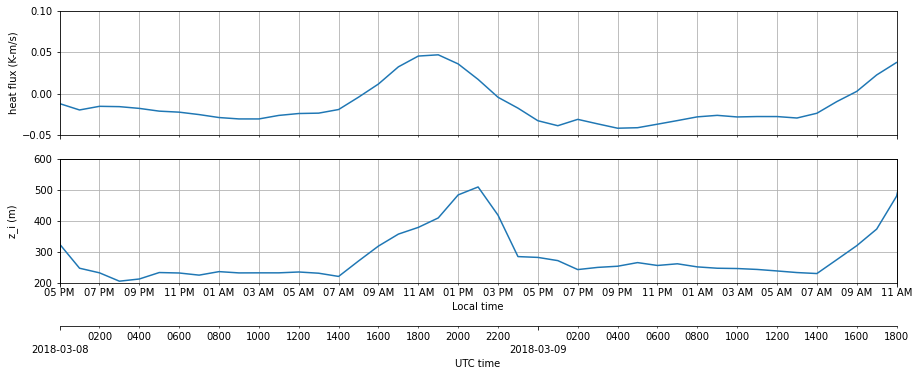

In [74]:
# there is a another good candidate 
fig, axs = plot_timehistory_at_height(
    df80,
    fields=['windspeed','winddirection','theta'],
    timelimits=[datefromlowq, datetolowq],
    fieldlimits={'winddirection':[230,280],'windspeed':[0,8],'theta':[272,282]},
    fieldlabels={'windspeed':'windspeed (m/s)', 'winddirection':'wind dir (deg)'},
    subfigsize=(15,2.5),
    #plot_local_time=True,
    #local_time_offset=-7,
)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_minor_locator(mdates.HourLocator(interval=2))

fig, ax1, ax2 = plot_timehistory_at_height(
    df,
    heights=0,
    fields=['hfx_Kms','z_i'],
    timelimits=[datefromlowq, datetolowq],
    fieldlimits={'hfx_Kms':[-0.05,0.1],'z_i':[200,600]},
    fieldlabels={'hfx_Kms':'heat flux (K-m/s)','z_i':'z_i (m)'},
    subfigsize=(15,2.5),
    plot_local_time=True,
    local_time_offset=-7,
)

#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1[0].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=2))

In [60]:
df.z_i

datetime                   height
2016-12-31 17:00:00-07:00  0.0       240.61145
                           2.0             NaN
                           10.0            NaN
                           20.0            NaN
                           40.0            NaN
                                       ...    
2018-12-31 16:00:00-07:00  120.0           NaN
                           140.0           NaN
                           160.0           NaN
                           180.0           NaN
                           200.0           NaN
Name: z_i, Length: 227760, dtype: float64

# Exporting ABLProperties tables for SOWFA


In [35]:
from mmctools.coupling.sowfa import InternalCoupling

In [36]:
diurnallowqpath = '/home/rthedin/OpenFOAM/rthedin-6/run/eagle_newWTK_totw/diurnal_lowq/constant/drivingData'
diurnalhighqpath = '/home/rthedin/OpenFOAM/rthedin-6/run/eagle_newWTK_totw/diurnal_highq/constant/drivingData'

### - Low heating case

In [54]:
# create internal coupling object (with one height for source term)
tosowfa80 = InternalCoupling(diurnallowqpath, df20km.loc[(slice(None),80),:], dateref=datefromlowq, datefrom=datefromlowq, dateto=datetolowq)
# write time-height data
tosowfa80.write_timeheight('fieldTable_80m',xmom='u', ymom='v', zmom='w',temp='theta')

In [62]:
# create internal coupling object (with all heights with value-- z>=10)
tosowfa = InternalCoupling(diurnallowqpath, df20km.loc[(slice(None),slice(10,None)),:], dateref=datefromlowq, datefrom=datefromlowq, dateto=datetolowq)
# write initial conditions
tosowfa.write_ICs('initialValues',xmom='u',ymom='v',temp='theta')

In [45]:
# write q time-history
qsowfa = InternalCoupling(diurnallowqpath, df20km.loc[(slice(None),0),:], dateref=datefromlowq, datefrom=datefromlowq, dateto=datetolowq)
#qsowfa.write_BCs('qwallTable_needsVectorAdjustment',fieldname='hfx_Kms',fact=-1.0)

### - High heating case

In [75]:
# create internal coupling object (with one height for source term)
tosowfa80 = InternalCoupling(diurnalhighqpath, df20km.loc[(slice(None),80),:], dateref=datefromhighq, datefrom=datefromhighq, dateto=datetohighq)
# write time-height data
tosowfa80.write_timeheight('fieldTable_80m',xmom='u', ymom='v', zmom='w',temp='theta')

In [76]:
# create internal coupling object (with all heights with value-- z>=10)
tosowfa = InternalCoupling(diurnalhighqpath, df20km.loc[(slice(None),slice(10,None)),:], dateref=datefromhighq, datefrom=datefromhighq, dateto=datetohighq)
# write initial conditions
tosowfa.write_ICs('initialValues',xmom='u',ymom='v',temp='theta')

In [77]:
# write q time-history
qsowfa = InternalCoupling(diurnalhighqpath, df20km.loc[(slice(None),0),:], dateref=datefromhighq, datefrom=datefromhighq, dateto=datetohighq)
qsowfa.write_BCs('qwallTable_needsVectorAdjustment',fieldname='hfx_Kms',fact=-1.0)

In [ ]:

def get_hours(lonlat: Tuple[float, float], timeofday: str, tzone: str, cur_day: datetime):
    """ returns list of hours based on coordinates """
    a=1
    return a

In [ ]:
import typing


In [ ]:
# Rimple's

def get_hours(lonlat, timeofday, tzone, cur_day):
    """ returns list of hours based on coordinates """
 
    aloc = astral.LocationInfo(name='name', region='region', timezone=tzone, longitude=lonlat[0], latitude=lonlat[1])
    sunloc = sun.sun(aloc.observer, date=cur_day.now().date(),
    tzinfo=aloc.timezone)
    srise = sunloc['sunrise'].hour + 1
    sset = sunloc['sunset'].hour + 1
    hours = np.array_split(np.array(range(srise, sset)), 3)
    if timeofday == 'morning':
        return list(hours[0])
    elif timeofday == 'afternoon':
        return list(hours[1])
    elif timeofday == 'evening':
        return list(hours[2])
    elif timeofday == 'daytime':
        return list(hours[0]) + list(hours[1]) + list(hours[2])
    else:
        raise Exception('Incorrect timeofday string\n \
        options: morning, afternoon, evening, daytime')